In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib as mpl
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
from matplotlib import pyplot
import sklearn.metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

In [144]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 12 23:54:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |    150MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [145]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
data = pd.read_csv("/content/drive/MyDrive/Data_AM/train_ultimo_per.csv")


In [ ]:
#data = pd.read_csv("/content/drive/MyDrive/Data_AM/train_ultimo_per.csv")

'/content'

In [148]:
data.dtypes

customer_ID     object
P_2            float64
D_39           float64
B_1            float64
B_2            float64
                ...   
D_120          float64
D_126            int64
D_63            object
D_64            object
D_68           float64
Length: 170, dtype: object

Categoricas que hay que usar:B_30, B_38, D_114, D_117, D_120, D_126, D_63, D_64, D_68

In [149]:
#Pasar a object las categoricas
data['B_30'] =  data['B_30'].astype(str)
data['B_38'] =  data['B_38'].astype(str)
data['D_114'] =  data['D_114'].astype(str)
data['D_117'] =  data['D_117'].astype(str)
data['D_120'] =  data['D_120'].astype(str)
data['D_126'] =  data['D_126'].astype(str)
data['D_63'] =  data['D_63'].astype(str)
data['D_64'] =  data['D_64'].astype(str)
data['D_68'] =  data['D_68'].astype(str)

In [150]:
print(f"B_30= {data['B_30'].unique()}")
print(f"B_38= {data['B_38'].unique()}")
print(f"D_114= {data['D_114'].unique()}")
print(f"D_117= {data['D_117'].unique()}")
print(f"D_120= {data['D_120'].unique()}")
print(f"D_126= {data['D_126'].unique()}")
print(f"D_63= {data['D_63'].unique()}")
print(f"D_64= {data['D_64'].unique()}")
print(f"D_68= {data['D_68'].unique()}")

B_30= ['0.0' '1.0' '2.0' 'nan']
B_38= ['2.0' '1.0' '3.0' '7.0' '5.0' '6.0' '4.0' 'nan']
D_114= ['1.0' '0.0' 'nan']
D_117= ['4.0' '-1.0' '6.0' '1.0' '2.0' '5.0' '3.0' 'nan']
D_120= ['0.0' '1.0' 'nan']
D_126= ['1' '0']
D_63= ['CR' 'CO' 'CL' 'XL' 'XZ' 'XM']
D_64= ['O' 'R' 'U' 'nan']
D_68= ['6.0' '3.0' '5.0' '4.0' '2.0' '1.0' 'nan']


### Análisis tipo de variables

In [151]:
#Variables categóricas

string_variables = data.select_dtypes(include = 'object').columns.values
(len(string_variables), string_variables)


(10, array(['customer_ID', 'B_30', 'B_38', 'D_114', 'D_117', 'D_120', 'D_126',
        'D_63', 'D_64', 'D_68'], dtype=object))

In [152]:
#Variables numéricas

number_variables = data.select_dtypes(include = 'number').columns.values
(len(number_variables), number_variables)

(160, array(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
        'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47',
        'D_48', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52',
        'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7',
        'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9',
        'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65',
        'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13',
        'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23',
        'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25',
        'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11',
        'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83',
        'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'D_87', 'R_17',
        'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21',
        'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93

In [153]:
#Verificar que checamos todos los tipos de variables

if (sum([len(number_variables), len(string_variables)]) == data.shape[1]): 
    print('Completo')
else:
    print('Faltan columnas')

Completo


#Generar el reporte
profile = ProfileReport(data, title="Pandas Profiling Reportv AMEX")
profile.to_notebook_iframe()
#Guardamos la salida en un archivo html
profile.to_file("/Users/Shanti/Desktop/Amex_data_profiling.html")

## Genera el data profiling de las variables 

#### Categoricas

In [154]:
def get_repeated_values(df, col, top):
    top_5 = df.groupby([col])[col]\
                    .count()\
                    .sort_values(ascending = False)\
                    .head()
    indexes_top_5 = top_5.index
    
    if ((top == 1) and (len(indexes_top_5) > 0)):
        return indexes_top_5[0]
    elif ((top == 2) and (len(indexes_top_5) > 1)):
        return indexes_top_5[1]
    elif ((top == 3) and (len(indexes_top_5) > 2)):
        return indexes_top_5[2]
    else: 
        return 'undefined'

In [155]:
def category_profiling(df, col, profiling_dict):
    """
    Profiling for categoric columns. 
    
    :param: column to analyze
    :return: dictionary
    """
    profiling = {}

    profiling.update({'mode': df[col].mode()[0],
                     'num_categories': df[col].nunique(),
                     'categories': df[col].unique(),
                     #'uniques': df[col].nunique(),
                     'missings': sum(df[col].isna())/df[col].size*100,
                     'top1_repeated': get_repeated_values(df, col, 1),
                     'top2_repeated': get_repeated_values(df, col, 2),
                     'top3_repeated': get_repeated_values(df, col, 3)})
    
    profiling_dict.update({col: profiling})
    
    return profiling_dict

In [156]:
profiling_category_dict = {}

category_profiling_output = [category_profiling(data, elem, profiling_category_dict)\
                             for elem in string_variables]

In [157]:
#category_profiling_output

df_category_profiling = pd.DataFrame(category_profiling_output[0]).reset_index()
df_category_profiling

,index,customer_ID,B_30,B_38,D_114,D_117,D_120,D_126,D_63,D_64,D_68
0,mode,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0,2.0,1.0,-1.0,0.0,1,CO,O,6.0
1,num_categories,458913,4,8,3,8,3,2,6,4,7
2,categories,[0000099d6bd597052cdcda90ffabf56573fe9d7c79be5...,"[0.0, 1.0, 2.0, nan]","[2.0, 1.0, 3.0, 7.0, 5.0, 6.0, 4.0, nan]","[1.0, 0.0, nan]","[4.0, -1.0, 6.0, 1.0, 2.0, 5.0, 3.0, nan]","[0.0, 1.0, nan]","[1, 0]","[CR, CO, CL, XL, XZ, XM]","[O, R, U, nan]","[6.0, 3.0, 5.0, 4.0, 2.0, 1.0, nan]"
3,missings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,top1_repeated,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0,2.0,1.0,-1.0,0.0,1,CO,O,6.0
5,top2_repeated,aab6cd60f43333ffbf74b6500af488da9966c9c5d7bb50...,1.0,3.0,0.0,3.0,1.0,0,CR,U,5.0
6,top3_repeated,aa5f0a0add6369c75c051f901120fbf459925ba2b4a813...,2.0,1.0,nan,4.0,nan,undefined,CL,R,3.0


In [158]:
print(f"B_30= {data['B_30'].isna().sum()}")
print(f"B_38= {data['B_38'].isna().sum()}")
print(f"D_114= {data['D_114'].isna().sum()}")
print(f"D_117= {data['D_117'].isna().sum()}")
print(f"D_120= {data['D_120'].isna().sum()}")
print(f"D_126= {data['D_126'].isna().sum()}")
print(f"D_63= {data['D_63'].isna().sum()}")
print(f"D_64= {data['D_64'].isna().sum()}")
print(f"D_68= {data['D_68'].isna().sum()}")

B_30= 0
B_38= 0
D_114= 0
D_117= 0
D_120= 0
D_126= 0
D_63= 0
D_64= 0
D_68= 0


#Reemplazamos todos los nan por other de las categoricas
data['B_30'].fillna('other',inplace=True)
data['B_38'].fillna('other',inplace=True)
data['D_114'].fillna('other',inplace=True)
data['D_117'].fillna('other',inplace=True)
data['D_120'].fillna('other',inplace=True)
data['D_126'].fillna('other',inplace=True)
data['D_63'].fillna('other',inplace=True)
data['D_64'].fillna('other',inplace=True)
data['D_68'].fillna('other',inplace=True)



print(f"B_30= {data['B_30'].isna().sum()}")
print(f"B_38= {data['B_38'].isna().sum()}")
print(f"D_114= {data['D_114'].isna().sum()}")
print(f"D_117= {data['D_117'].isna().sum()}")
print(f"D_120= {data['D_120'].isna().sum()}")
print(f"D_126= {data['D_126'].isna().sum()}")
print(f"D_63= {data['D_63'].isna().sum()}")
print(f"D_64= {data['D_64'].isna().sum()}")
print(f"D_68= {data['D_68'].isna().sum()}")

#### Numericas

In [159]:
# con talacha
def numeric_profiling(df, col, profiling_dict):
    """
    Profiling for numeric columns. 
    
    :param: column to analyze
    :return: dictionary
    """
    profiling = {}

    profiling.update({'max': df[col].max(),
                     'min': df[col].min(),
                     'mean': df[col].mean(),
                     'stdv': df[col].std(),
                     '25%': df[col].quantile(.25),
                     'median': df[col].median(),
                     '75%': df[col].quantile(.75),
                     'kurtosis': df[col].kurt(),
                     'skewness': df[col].skew(),
                     'uniques': df[col].nunique(),
                     'prop_missings': sum(df[col].isna())/df[col].size*100,
                     'top1_repeated': get_repeated_values(df, col, 1),
                     'top2_repeated': get_repeated_values(df, col, 2),
                     'top3_repeated': get_repeated_values(df, col, 3)})
    
    profiling_dict.update({col: profiling})
    
    return profiling_dict

In [160]:
profiling_dict = {}

numeric_profiling_output = [numeric_profiling(data, elem, profiling_dict)\
                            for elem in number_variables]

In [161]:
df_numeric_profiling = pd.DataFrame(numeric_profiling_output[0]).reset_index()
df_numeric_profiling.rename(columns={'index': 'metric'}, inplace=True)
df_numeric_profiling

,metric,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_131,D_133,R_28,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,max,1.009998,5.001550e+00,1.324059,1.010000e+00,2.759738e+00,3.993525,8.988807e+00,1.596532e+00,4.186138,...,1.491624e+00,1.509998e+00,1.009960e+00,1.010000e+00,1.010000e+00,1.339910e+00,2.229182,1.010000e+00,1.343326e+00,4.827630e+00
1,min,-0.458955,7.406592e-08,-3.571172,2.024839e-07,5.646122e-08,-0.508883,3.998730e-08,7.574315e-08,-0.000240,...,5.461693e-09,1.243154e-09,4.549750e-08,2.207831e-08,7.897955e-09,9.490087e-08,-0.011438,1.653580e-08,1.995319e-08,2.811854e-09
2,mean,0.635249,2.014895e-01,0.139027,5.916128e-01,1.073958e-01,0.229064,9.948801e-02,1.548291e-01,0.177988,...,1.167025e-01,5.146633e-02,5.660658e-03,1.811025e-01,2.893126e-02,1.665783e-01,0.394761,1.809953e-01,5.201583e-02,6.379602e-02
3,stdv,0.267547,4.021565e-01,0.231266,4.121456e-01,2.786386e-01,0.198845,3.040705e-01,2.550615e-01,0.253631,...,3.122695e-01,1.828866e-01,2.588725e-02,3.809093e-01,1.528808e-01,3.501717e-01,0.241254,3.808317e-01,1.820323e-01,1.970930e-01
4,25%,0.449332,4.782223e-03,0.008984,7.091162e-02,2.957326e-03,0.127512,3.008724e-03,5.483745e-03,0.031770,...,2.823318e-03,2.754521e-03,2.504165e-03,3.045516e-03,2.551175e-03,3.027869e-03,0.200727,3.032092e-03,2.757897e-03,3.031604e-03
5,median,0.682559,9.559730e-03,0.033219,8.134054e-01,5.920879e-03,0.164910,6.010615e-03,1.082996e-02,0.108293,...,5.645906e-03,5.517986e-03,4.998674e-03,6.078699e-03,5.120597e-03,6.050620e-03,0.386107,6.065281e-03,5.501409e-03,6.072661e-03
6,75%,0.862186,2.665587e-01,0.153634,1.001955e+00,8.891468e-03,0.264784,8.998209e-03,2.106605e-01,0.230394,...,8.457952e-03,8.264314e-03,7.498714e-03,9.101306e-03,7.674505e-03,9.101263e-03,0.573958,9.097647e-03,8.251762e-03,9.101820e-03
7,kurtosis,-0.219455,1.639678e+01,6.711370,-1.619576e+00,1.205459e+01,15.680271,3.816850e+01,3.152123e+00,46.848990,...,3.954958e+00,2.575421e+01,1.467481e+03,8.923334e-01,3.677881e+01,9.703298e-01,0.271645,8.953719e-01,2.030650e+01,4.065024e+01
8,skewness,-0.681382,3.595900e+00,2.491184,-4.205407e-01,3.288562e+00,3.060651,5.165237e+00,1.945054e+00,5.234599,...,2.438966e+00,4.843087e+00,3.809447e+01,1.700569e+00,6.226026e+00,1.715385e+00,0.458831,1.701462e+00,4.439640e+00,5.471476e+00
9,uniques,455944.000000,4.589130e+05,458913.000000,4.588820e+05,4.589130e+05,373943.000000,4.588820e+05,4.588820e+05,59910.000000,...,4.560830e+05,4.589130e+05,4.589130e+05,4.560830e+05,4.589130e+05,4.560830e+05,80315.000000,4.560830e+05,4.589130e+05,4.560830e+05


#Contar cuantas observaciones vacías tienen las variables numericas
print(f"P_2= {data['P_2'].isna().sum()}")
print(f"D_39= {data['D_39'].isna().sum()}")
print(f"B_1= {data['B_1'].isna().sum()}")
print(f"B_2= {data['B_2'].isna().sum()}")
print(f"R_1= {data['R_1'].isna().sum()}")
print(f"S_3= {data['S_3'].isna().sum()}")
print(f"B_3= {data['B_3'].isna().sum()}")
print(f"D_42= {data['D_42'].isna().sum()}")
print(f"D_43= {data['D_43'].isna().sum()}")
print(f"D_44= {data['D_44'].isna().sum()}")
print(f"B_4= {data['B_4'].isna().sum()}")
print(f"B_5= {data['B_5'].isna().sum()}")
print(f"R_2= {data['R_2'].isna().sum()}")
print(f"D_46= {data['D_46'].isna().sum()}")
print(f"D_47= {data['D_47'].isna().sum()}")
print(f"D_48= {data['D_48'].isna().sum()}")
print(f"B_6= {data['B_6'].isna().sum()}")
print(f"B_7= {data['B_7'].isna().sum()}")
print(f"B_8= {data['B_8'].isna().sum()}")
print(f"D_50= {data['D_50'].isna().sum()}")
print(f"D_51= {data['D_51'].isna().sum()}")
print(f"B_9= {data['B_9'].isna().sum()}")
print(f"R_3= {data['R_3'].isna().sum()}")
print(f"D_52= {data['D_52'].isna().sum()}")
print(f"P_3= {data['P_3'].isna().sum()}")
print(f"B_10= {data['B_10'].isna().sum()}")
print(f"D_53= {data['D_53'].isna().sum()}")
print(f"S_5= {data['S_5'].isna().sum()}")
print(f"B_11= {data['B_11'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"D_54= {data['D_54'].isna().sum()}")
print(f"R_4= {data['R_4'].isna().sum()}")
print(f"S_7= {data['S_7'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")
print(f"S_6= {data['S_6'].isna().sum()}")

1. ¿Cuál es la variable target? Churn

**Es peor decir que no se salen los clientes cuando sí**

- Etiqueta Positiva= Sí abandona la compañía
- Etiqueta Negativa= No abandona la compañía 
- TP= el modelos dice que abandona y la etiqueta real dice que sí abandona
- TN= el modelo dice que no abondona y la etiqueta real dice que no abondona
- FN= el modelo dice que no abandona y la etiqueta real dice que sí abandona -> **Queremos reducir esta**
- FP=el modelo dice que sí abandona y la etiqueta real dice que no abandona

**Debemos optimizar: minimizar FN
Minimizar los FN porque le sale más caro a una empresa pensar que sí cuenta con esos clientes cuando en realidad ya no. 

**¿Qué métrica de desempeño deberás optimizar para cumplir con el punto anterior**

Nos importa más **Recall** =TP/(TP+FN). Esta métrica la ocupamos cuando en el contexto de negocio del problema es más conveniente minimizar los falsos negativos. Consideramos también que era mejor ocupar **recall**, ya que sirve para modelos en los que se quiere hacer intervenciones positivas. En este caso, queremos predecir estos clientes que se quieren ir y evitar que se vayan.

In [162]:
data_trainlabels = pd.read_csv("/content/drive/MyDrive/Data_AM/train_labels.csv")
data_trainlabels.dtypes

customer_ID    object
target          int64
dtype: object

In [163]:
data_trainlabels.shape[0]

458913

In [164]:
data_trainlabels.head(3)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0


In [165]:
data.head(3)

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_145,B_30,B_38,D_114,D_117,D_120,D_126,D_63,D_64,D_68
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,NaN,...,0.008533,0.0,2.0,1.0,4.0,0.0,1,CR,O,6.0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,NaN,...,0.008514,0.0,2.0,1.0,-1.0,0.0,1,CO,O,6.0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.880875,0.009704,0.004284,0.812650,0.006450,NaN,0.003796,0.007196,NaN,...,0.003444,0.0,1.0,1.0,-1.0,0.0,1,CO,R,6.0


In [166]:
data.shape[0]

458913

In [167]:
#Unir target variable al dataset
data_full=data_trainlabels.merge(data,how='inner',left_on='customer_ID', right_on='customer_ID')
data_full.head(3)

,customer_ID,target,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_145,B_30,B_38,D_114,D_117,D_120,D_126,D_63,D_64,D_68
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,...,0.008533,0.0,2.0,1.0,4.0,0.0,1,CR,O,6.0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,...,0.008514,0.0,2.0,1.0,-1.0,0.0,1,CO,O,6.0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.880875,0.009704,0.004284,0.812650,0.006450,NaN,0.003796,0.007196,...,0.003444,0.0,1.0,1.0,-1.0,0.0,1,CO,R,6.0


### Preprocesamiento

Categoricas que hay que usar:B_30, B_38, D_114, D_117, D_120, D_126, D_63, D_64, D_68

In [168]:
ohe = OneHotEncoder()

In [169]:
# Le pasamos las variables que queremos cambiar:
database_aux=data_full[['B_30', 'B_38', 'D_114', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']]
database_aux
X_ohe =ohe.fit(database_aux)
X_ohe_t=X_ohe.transform(database_aux)
X_ohe_t.toarray()

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [ ]:
#database_aux.isnull().any()


In [170]:
database_aux.dtypes

B_30     object
B_38     object
D_114    object
D_117    object
D_120    object
D_126    object
D_63     object
D_64     object
D_68     object
dtype: object

In [171]:
X_ohe.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_0.0', 'x0_1.0', 'x0_2.0', 'x0_nan', 'x1_1.0', 'x1_2.0',
       'x1_3.0', 'x1_4.0', 'x1_5.0', 'x1_6.0', 'x1_7.0', 'x1_nan',
       'x2_0.0', 'x2_1.0', 'x2_nan', 'x3_-1.0', 'x3_1.0', 'x3_2.0',
       'x3_3.0', 'x3_4.0', 'x3_5.0', 'x3_6.0', 'x3_nan', 'x4_0.0',
       'x4_1.0', 'x4_nan', 'x5_0', 'x5_1', 'x6_CL', 'x6_CO', 'x6_CR',
       'x6_XL', 'x6_XM', 'x6_XZ', 'x7_O', 'x7_R', 'x7_U', 'x7_nan',
       'x8_1.0', 'x8_2.0', 'x8_3.0', 'x8_4.0', 'x8_5.0', 'x8_6.0',
       'x8_nan'], dtype=object)

In [172]:
print(f"B_30= {data['B_30'].unique()}")
print(f"B_38= {data['B_38'].unique()}")
print(f"D_114= {data['D_114'].unique()}")
print(f"D_117= {data['D_117'].unique()}")
print(f"D_120= {data['D_120'].unique()}")
print(f"D_126= {data['D_126'].unique()}")
print(f"D_63= {data['D_63'].unique()}")
print(f"D_64= {data['D_64'].unique()}")
print(f"D_68= {data['D_68'].unique()}")

B_30= ['0.0' '1.0' '2.0' 'nan']
B_38= ['2.0' '1.0' '3.0' '7.0' '5.0' '6.0' '4.0' 'nan']
D_114= ['1.0' '0.0' 'nan']
D_117= ['4.0' '-1.0' '6.0' '1.0' '2.0' '5.0' '3.0' 'nan']
D_120= ['0.0' '1.0' 'nan']
D_126= ['1' '0']
D_63= ['CR' 'CO' 'CL' 'XL' 'XZ' 'XM']
D_64= ['O' 'R' 'U' 'nan']
D_68= ['6.0' '3.0' '5.0' '4.0' '2.0' '1.0' 'nan']


In [173]:
df_ohe = pd.DataFrame(list(X_ohe_t.toarray()), columns=['x0_0.0', 'x0_1.0', 'x0_2.0', 'x0_nan', 'x1_1.0', 'x1_2.0',
       'x1_3.0', 'x1_4.0', 'x1_5.0', 'x1_6.0', 'x1_7.0', 'x1_nan',
       'x2_0.0', 'x2_1.0', 'x2_nan', 'x3_-1.0', 'x3_1.0', 'x3_2.0',
       'x3_3.0', 'x3_4.0', 'x3_5.0', 'x3_6.0', 'x3_nan', 'x4_0.0',
       'x4_1.0', 'x4_nan', 'x5_0', 'x5_1', 'x6_CL', 'x6_CO', 'x6_CR',
       'x6_XL', 'x6_XM', 'x6_XZ', 'x7_O', 'x7_R', 'x7_U', 'x7_nan',
       'x8_1.0', 'x8_2.0', 'x8_3.0', 'x8_4.0', 'x8_5.0', 'x8_6.0',
       'x8_nan'])

df_ohe

,x0_0.0,x0_1.0,x0_2.0,x0_nan,x1_1.0,x1_2.0,x1_3.0,x1_4.0,x1_5.0,x1_6.0,...,x7_R,x7_U,x7_nan,x8_1.0,x8_2.0,x8_3.0,x8_4.0,x8_5.0,x8_6.0,x8_nan
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458910,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
458911,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [174]:
df_ohe.dtypes

x0_0.0     float64
x0_1.0     float64
x0_2.0     float64
x0_nan     float64
x1_1.0     float64
x1_2.0     float64
x1_3.0     float64
x1_4.0     float64
x1_5.0     float64
x1_6.0     float64
x1_7.0     float64
x1_nan     float64
x2_0.0     float64
x2_1.0     float64
x2_nan     float64
x3_-1.0    float64
x3_1.0     float64
x3_2.0     float64
x3_3.0     float64
x3_4.0     float64
x3_5.0     float64
x3_6.0     float64
x3_nan     float64
x4_0.0     float64
x4_1.0     float64
x4_nan     float64
x5_0       float64
x5_1       float64
x6_CL      float64
x6_CO      float64
x6_CR      float64
x6_XL      float64
x6_XM      float64
x6_XZ      float64
x7_O       float64
x7_R       float64
x7_U       float64
x7_nan     float64
x8_1.0     float64
x8_2.0     float64
x8_3.0     float64
x8_4.0     float64
x8_5.0     float64
x8_6.0     float64
x8_nan     float64
dtype: object

In [175]:
#Añadimos las otras variables, las numericas
df_ohe['P_2'] = data_full.P_2
df_ohe['D_39'] = data_full.D_39
df_ohe['B_1'] = data_full.B_1
df_ohe['B_2'] = data_full.B_2
df_ohe['R_1'] = data_full.R_1
df_ohe['S_3'] = data_full.S_3
df_ohe['D_41'] = data_full.D_41
df_ohe['B_3'] = data_full.B_3
df_ohe['D_42'] = data_full.D_42
df_ohe['D_43'] = data_full.D_43
df_ohe['D_44'] = data_full.D_44
df_ohe['B_4'] = data_full.B_4
df_ohe['D_45'] = data_full.D_45
df_ohe['B_5'] = data_full.B_5
df_ohe['R_2'] = data_full.R_2
df_ohe['D_46'] = data_full.D_46
df_ohe['D_47'] = data_full.D_47
df_ohe['D_48'] = data_full.D_48
df_ohe['B_6'] = data_full.B_6
df_ohe['B_7'] = data_full.B_7
df_ohe['B_8'] = data_full.B_8
df_ohe['D_50'] = data_full.D_50
df_ohe['D_51'] = data_full.D_51
df_ohe['B_9'] = data_full.B_9
df_ohe['R_3'] = data_full.R_3
df_ohe['D_52'] = data_full.D_52
df_ohe['P_3'] = data_full.P_3
df_ohe['B_10'] = data_full.B_10
df_ohe['D_53'] = data_full.D_53
df_ohe['S_5'] = data_full.S_5
df_ohe['B_11'] = data_full.B_11
df_ohe['S_6'] = data_full.S_6
df_ohe['D_54'] = data_full.D_54
df_ohe['R_4'] = data_full.R_4
df_ohe['S_7'] = data_full.S_7
df_ohe['B_12'] = data_full.B_12
df_ohe['S_8'] = data_full.S_8
df_ohe['D_55'] = data_full.D_55
df_ohe['D_56'] = data_full.D_56
df_ohe['B_13'] = data_full.B_13
df_ohe['R_5'] = data_full.R_5
df_ohe['D_58'] = data_full.D_58
df_ohe['S_9'] = data_full.S_9
df_ohe['B_14'] = data_full.B_14
df_ohe['D_59'] = data_full.D_59
df_ohe['D_60'] = data_full.D_60
df_ohe['D_61'] = data_full.D_61
df_ohe['B_15'] = data_full.B_15
df_ohe['S_11'] = data_full.S_11
df_ohe['D_62'] = data_full.D_62
df_ohe['D_65'] = data_full.D_65
df_ohe['B_16'] = data_full.B_16
df_ohe['B_17'] = data_full.B_17
df_ohe['B_18'] = data_full.B_18
df_ohe['B_19'] = data_full.B_19
df_ohe['B_20'] = data_full.B_20
df_ohe['S_12'] = data_full.S_12
df_ohe['R_6'] = data_full.R_6
df_ohe['S_13'] = data_full.S_13
df_ohe['B_21'] = data_full.B_21
df_ohe['D_69'] = data_full.D_69
df_ohe['B_22'] = data_full.B_22
df_ohe['D_70'] = data_full.D_70
df_ohe['D_71'] = data_full.D_71
df_ohe['D_72'] = data_full.D_72
df_ohe['S_15'] = data_full.S_15
df_ohe['B_23'] = data_full.B_23
df_ohe['P_4'] = data_full.P_4
df_ohe['D_74'] = data_full.D_74
df_ohe['D_75'] = data_full.D_75
df_ohe['D_76'] = data_full.D_76
df_ohe['B_24'] = data_full.B_24
df_ohe['R_7'] = data_full.R_7
df_ohe['D_77'] = data_full.D_77
df_ohe['B_25'] = data_full.B_25
df_ohe['B_26'] = data_full.B_26
df_ohe['D_78'] = data_full.D_78
df_ohe['D_79'] = data_full.D_79
df_ohe['R_8'] = data_full.R_8
df_ohe['S_16'] = data_full.S_16
df_ohe['D_80'] = data_full.D_80
df_ohe['R_10'] = data_full.R_10
df_ohe['R_11'] = data_full.R_11
df_ohe['B_27'] = data_full.B_27
df_ohe['D_81'] = data_full.D_81
df_ohe['D_82'] = data_full.D_82
df_ohe['S_17'] = data_full.S_17
df_ohe['R_12'] = data_full.R_12
df_ohe['B_28'] = data_full.B_28
df_ohe['R_13'] = data_full.R_13
df_ohe['D_83'] = data_full.D_83
df_ohe['R_14'] = data_full.R_14
df_ohe['R_15'] = data_full.R_15
df_ohe['D_84'] = data_full.D_84
df_ohe['R_16'] = data_full.R_16
df_ohe['S_18'] = data_full.S_18
df_ohe['D_86'] = data_full.D_86
df_ohe['D_87'] = data_full.D_87
df_ohe['R_17'] = data_full.R_17
df_ohe['R_18'] = data_full.R_18
df_ohe['B_31'] = data_full.B_31
df_ohe['S_19'] = data_full.S_19
df_ohe['R_19'] = data_full.R_19
df_ohe['B_32'] = data_full.B_32
df_ohe['S_20'] = data_full.S_20
df_ohe['R_20'] = data_full.R_20
df_ohe['R_21'] = data_full.R_21
df_ohe['B_33'] = data_full.B_33
df_ohe['D_89'] = data_full.D_89
df_ohe['R_22'] = data_full.R_22
df_ohe['R_23'] = data_full.R_23
df_ohe['D_91'] = data_full.D_91
df_ohe['D_92'] = data_full.D_92
df_ohe['D_93'] = data_full.D_93
df_ohe['D_94'] = data_full.D_94
df_ohe['R_24'] = data_full.R_24
df_ohe['R_25'] = data_full.R_25
df_ohe['D_96'] = data_full.D_96
df_ohe['S_22'] = data_full.S_22
df_ohe['S_23'] = data_full.S_23
df_ohe['S_24'] = data_full.S_24
df_ohe['S_25'] = data_full.S_25
df_ohe['S_26'] = data_full.S_26
df_ohe['D_102'] = data_full.D_102
df_ohe['D_103'] = data_full.D_103
df_ohe['D_104'] = data_full.D_104
df_ohe['D_105'] = data_full.D_105
df_ohe['D_107'] = data_full.D_107
df_ohe['B_36'] = data_full.B_36
df_ohe['B_37'] = data_full.B_37
df_ohe['R_26'] = data_full.R_26
df_ohe['R_27'] = data_full.R_27
df_ohe['D_109'] = data_full.D_109
df_ohe['D_112'] = data_full.D_112
df_ohe['B_40'] = data_full.B_40
df_ohe['S_27'] = data_full.S_27
df_ohe['D_113'] = data_full.D_113
df_ohe['D_115'] = data_full.D_115
df_ohe['D_118'] = data_full.D_118
df_ohe['D_119'] = data_full.D_119
df_ohe['D_121'] = data_full.D_121
df_ohe['D_122'] = data_full.D_122
df_ohe['D_123'] = data_full.D_123
df_ohe['D_124'] = data_full.D_124
df_ohe['D_125'] = data_full.D_125
df_ohe['D_127'] = data_full.D_127
df_ohe['D_128'] = data_full.D_128
df_ohe['D_129'] = data_full.D_129
df_ohe['B_41'] = data_full.B_41
df_ohe['D_130'] = data_full.D_130
df_ohe['D_131'] = data_full.D_131
df_ohe['D_133'] = data_full.D_133
df_ohe['R_28'] = data_full.R_28
df_ohe['D_139'] = data_full.D_139
df_ohe['D_140'] = data_full.D_140
df_ohe['D_141'] = data_full.D_141
df_ohe['D_142'] = data_full.D_142
df_ohe['D_143'] = data_full.D_143
df_ohe['D_144'] = data_full.D_144
df_ohe['D_145'] = data_full.D_145

df_ohe

<ipython-input-175-0760ce1b35aa>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ohe['R_18'] = data_full.R_18
<ipython-input-175-0760ce1b35aa>:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ohe['B_31'] = data_full.B_31
<ipython-input-175-0760ce1b35aa>:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe 

,x0_0.0,x0_1.0,x0_2.0,x0_nan,x1_1.0,x1_2.0,x1_3.0,x1_4.0,x1_5.0,x1_6.0,...,D_131,D_133,R_28,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.005702,0.006210,0.002715,0.007186,0.004234,0.005086,NaN,0.005810,0.002970,0.008533
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.001928,0.002996,0.001701,0.002980,0.007479,0.007870,NaN,0.003284,0.003169,0.008514
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.003470,0.009881,0.007691,0.007383,0.006623,0.000964,NaN,0.002202,0.000834,0.003444
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.004576,0.001789,0.005140,0.002704,0.006184,0.001899,NaN,0.008183,0.005560,0.002983
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.008897,0.005045,0.003706,0.002974,0.004162,0.005764,NaN,0.008154,0.006944,0.000905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.009489,0.002072,0.004589,0.007917,0.001520,0.005530,NaN,0.001430,0.003009,0.004843
458909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.006120,1.128725,0.004884,0.004393,0.006185,0.001480,NaN,0.004794,0.009230,0.006435
458910,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.003282,0.004513,0.008924,0.006035,0.002869,0.002149,NaN,0.008031,0.000340,0.002148
458911,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.002679,0.000479,0.006828,1.009894,0.004478,0.949723,0.446255,1.009310,0.002502,0.185527


In [176]:
df_ohe['target'] = data_full.target

<ipython-input-176-5eafdf84f987>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ohe['target'] = data_full.target


In [177]:
#Checamos que estén todas las varibles y su tipo 
df_ohe.dtypes

x0_0.0    float64
x0_1.0    float64
x0_2.0    float64
x0_nan    float64
x1_1.0    float64
           ...   
D_142     float64
D_143     float64
D_144     float64
D_145     float64
target      int64
Length: 206, dtype: object

# ## Modelado - XGboost

In [178]:
#Calcular procentaje de los datos con etiqueta positiva

data_full.target.value_counts(normalize=True)

0    0.741066
1    0.258934
Name: target, dtype: float64

El 25.89% de los datos son etiqueta positiva. Es decir, abandonaron la compañía y el 74.10% no abandonó la compañía.

In [179]:
#Variable dependiente/ target
y = df_ohe.target
y.shape

(458913,)

In [180]:
#Variables independientes/ explicativas
X = df_ohe.filter(['x0_0.0', 'x0_1.0', 'x0_2.0', 'x0_nan', 'x1_1.0', 'x1_2.0',
       'x1_3.0', 'x1_4.0', 'x1_5.0', 'x1_6.0', 'x1_7.0', 'x1_nan',
       'x2_0.0', 'x2_1.0', 'x2_nan', 'x3_-1.0', 'x3_1.0', 'x3_2.0',
       'x3_3.0', 'x3_4.0', 'x3_5.0', 'x3_6.0', 'x3_nan', 'x4_0', 'x4_1',
       'x5_0', 'x5_1', 'x6_CL', 'x6_CO', 'x6_CR', 'x6_XL', 'x6_XM',
       'x6_XZ', 'x7_O', 'x7_R', 'x7_U', 'x7_nan', 'x8_1.0', 'x8_2.0',
       'x8_3.0', 'x8_4.0', 'x8_5.0', 'x8_6.0', 'x8_nan','P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
        'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47',
        'D_48', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52',
        'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7',
        'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9',
        'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65',
        'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13',
        'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23',
        'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25',
        'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11',
        'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83',
        'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'D_87', 'R_17',
        'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21',
        'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94',
        'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26',
        'D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'B_36', 'B_37',
        'R_26', 'R_27', 'D_109', 'D_112', 'B_40', 'S_27', 'D_113', 'D_115',
        'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125',
        'D_127', 'D_128', 'D_129', 'B_41', 'D_130', 'D_131', 'D_133',
        'R_28', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
        'D_145'],axis=1)
X.shape


(458913, 202)

In [181]:
np.random.seed(210418)

In [182]:
from sklearn.model_selection import train_test_split

# train test split usando el 25% de los datos para test
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20)
print("\nX_train, y_train: ", (X_train.shape, y_train.shape))
print("\nX_test, y_test: ", (X_test.shape, y_test.shape))



X_train, y_train:  ((367130, 202), (367130,))

X_test, y_test:  ((91783, 202), (91783,))


In [183]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)


In [ ]:
param = {'max_depth': 4, 'eta': 0.05, 'objective': 'binary:logistic', 'colsample_bynode': 0.3 }
param['eval_metric'] = 'logloss'

In [ ]:
param

{'max_depth': 2,
 'eta': 0.1,
 'objective': 'binary:logistic',
 'colsample_bytree': 0.3,
 'eval_metric': 'logloss'}

In [ ]:
evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [ ]:
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.637932	eval-logloss:0.637711
[1]	train-logloss:0.594103	eval-logloss:0.593682
[2]	train-logloss:0.558087	eval-logloss:0.557585
[3]	train-logloss:0.523943	eval-logloss:0.523285
[4]	train-logloss:0.497081	eval-logloss:0.496359
[5]	train-logloss:0.473866	eval-logloss:0.473179
[6]	train-logloss:0.453049	eval-logloss:0.452475
[7]	train-logloss:0.432777	eval-logloss:0.432119
[8]	train-logloss:0.415181	eval-logloss:0.414491
[9]	train-logloss:0.399969	eval-logloss:0.399245
[10]	train-logloss:0.387176	eval-logloss:0.386497
[11]	train-logloss:0.375127	eval-logloss:0.374456
[12]	train-logloss:0.365367	eval-logloss:0.364747
[13]	train-logloss:0.356318	eval-logloss:0.355705
[14]	train-logloss:0.348611	eval-logloss:0.348068
[15]	train-logloss:0.341434	eval-logloss:0.340988
[16]	train-logloss:0.335338	eval-logloss:0.334865
[17]	train-logloss:0.3294	eval-logloss:0.328943
[18]	train-logloss:0.324124	eval-logloss:0.323582
[19]	train-logloss:0.318156	eval-logloss:0.317563
[20]	train-l

In [189]:
#Modelo
param = {'max_depth': 4, 'eta': 0.05, 'objective': 'binary:logistic', 'colsample_bynode': 0.05 }
param['eval_metric'] = 'logloss'
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.665872	eval-logloss:0.665893
[1]	train-logloss:0.638143	eval-logloss:0.638086
[2]	train-logloss:0.615601	eval-logloss:0.615483
[3]	train-logloss:0.593616	eval-logloss:0.593539
[4]	train-logloss:0.573806	eval-logloss:0.573732
[5]	train-logloss:0.555947	eval-logloss:0.555924
[6]	train-logloss:0.53899	eval-logloss:0.538988
[7]	train-logloss:0.522875	eval-logloss:0.522819
[8]	train-logloss:0.508067	eval-logloss:0.507992
[9]	train-logloss:0.494617	eval-logloss:0.494456
[10]	train-logloss:0.482414	eval-logloss:0.482252
[11]	train-logloss:0.469081	eval-logloss:0.468832
[12]	train-logloss:0.456186	eval-logloss:0.455883
[13]	train-logloss:0.445249	eval-logloss:0.444944
[14]	train-logloss:0.435077	eval-logloss:0.4348
[15]	train-logloss:0.425839	eval-logloss:0.425574
[16]	train-logloss:0.417405	eval-logloss:0.417132
[17]	train-logloss:0.409542	eval-logloss:0.40927
[18]	train-logloss:0.401793	eval-logloss:0.401479
[19]	train-logloss:0.393613	eval-logloss:0.393277
[20]	train-log

In [ ]:
#Iteración 3
param = {'max_depth': 4, 'eta': 0.01, 'objective': 'binary:logistic', 'colsample_bynode': 0.05 }
param['eval_metric'] = 'logloss'
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.68758	eval-logloss:0.687584
[1]	train-logloss:0.681522	eval-logloss:0.68151
[2]	train-logloss:0.676196	eval-logloss:0.676169
[3]	train-logloss:0.67069	eval-logloss:0.67067
[4]	train-logloss:0.665356	eval-logloss:0.665339
[5]	train-logloss:0.660288	eval-logloss:0.660284
[6]	train-logloss:0.655126	eval-logloss:0.655121
[7]	train-logloss:0.650006	eval-logloss:0.649986
[8]	train-logloss:0.645061	eval-logloss:0.64503
[9]	train-logloss:0.640258	eval-logloss:0.640199
[10]	train-logloss:0.635783	eval-logloss:0.635716
[11]	train-logloss:0.630724	eval-logloss:0.63063
[12]	train-logloss:0.625601	eval-logloss:0.625497
[13]	train-logloss:0.621017	eval-logloss:0.6209
[14]	train-logloss:0.616447	eval-logloss:0.616339
[15]	train-logloss:0.612072	eval-logloss:0.611962
[16]	train-logloss:0.607903	eval-logloss:0.607789
[17]	train-logloss:0.603786	eval-logloss:0.603669
[18]	train-logloss:0.599661	eval-logloss:0.599528
[19]	train-logloss:0.595185	eval-logloss:0.595033
[20]	train-logloss

In [ ]:
#Iteración 4
param = {'max_depth': 4, 'eta': 0.1, 'objective': 'binary:logistic', 'colsample_bynode': 0.05 }
param['eval_metric'] = 'logloss'
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.639992	eval-logloss:0.640036
[1]	train-logloss:0.590346	eval-logloss:0.590253
[2]	train-logloss:0.553427	eval-logloss:0.553261
[3]	train-logloss:0.519343	eval-logloss:0.519242
[4]	train-logloss:0.491288	eval-logloss:0.49118
[5]	train-logloss:0.467206	eval-logloss:0.467206
[6]	train-logloss:0.44597	eval-logloss:0.445983
[7]	train-logloss:0.426273	eval-logloss:0.426213
[8]	train-logloss:0.409245	eval-logloss:0.409177
[9]	train-logloss:0.394853	eval-logloss:0.394686
[10]	train-logloss:0.381963	eval-logloss:0.381809
[11]	train-logloss:0.368109	eval-logloss:0.367856
[12]	train-logloss:0.355261	eval-logloss:0.354967
[13]	train-logloss:0.345064	eval-logloss:0.344827
[14]	train-logloss:0.336262	eval-logloss:0.336123
[15]	train-logloss:0.328608	eval-logloss:0.32849
[16]	train-logloss:0.321863	eval-logloss:0.321701
[17]	train-logloss:0.315833	eval-logloss:0.315614
[18]	train-logloss:0.310036	eval-logloss:0.309765
[19]	train-logloss:0.303995	eval-logloss:0.303716
[20]	train-lo

In [185]:
#Iteración 5
param = {'max_depth': 3, 'eta': 0.05, 'objective': 'binary:logistic', 'colsample_bynode': 0.05 }
param['eval_metric'] = 'logloss'
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.667908	eval-logloss:0.667923
[1]	train-logloss:0.640931	eval-logloss:0.640807
[2]	train-logloss:0.618952	eval-logloss:0.618783
[3]	train-logloss:0.597875	eval-logloss:0.597694
[4]	train-logloss:0.578395	eval-logloss:0.578213
[5]	train-logloss:0.561367	eval-logloss:0.561218
[6]	train-logloss:0.544466	eval-logloss:0.544329
[7]	train-logloss:0.528878	eval-logloss:0.528649
[8]	train-logloss:0.514356	eval-logloss:0.514095
[9]	train-logloss:0.501422	eval-logloss:0.501067
[10]	train-logloss:0.489715	eval-logloss:0.489384
[11]	train-logloss:0.476418	eval-logloss:0.476
[12]	train-logloss:0.463561	eval-logloss:0.463073
[13]	train-logloss:0.455583	eval-logloss:0.455108
[14]	train-logloss:0.445818	eval-logloss:0.445383
[15]	train-logloss:0.437624	eval-logloss:0.437181
[16]	train-logloss:0.42925	eval-logloss:0.428778
[17]	train-logloss:0.421704	eval-logloss:0.421235
[18]	train-logloss:0.414204	eval-logloss:0.413668
[19]	train-logloss:0.406995	eval-logloss:0.406427
[20]	train-log

In [186]:
#Iteración
param = {'max_depth': 4, 'eta': 0.05, 'objective': 'binary:logistic', 'colsample_bynode': 0.1 }
param['eval_metric'] = 'logloss'
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.664794	eval-logloss:0.664839
[1]	train-logloss:0.637298	eval-logloss:0.637377
[2]	train-logloss:0.612194	eval-logloss:0.612206
[3]	train-logloss:0.590077	eval-logloss:0.590116
[4]	train-logloss:0.569416	eval-logloss:0.569446
[5]	train-logloss:0.55159	eval-logloss:0.551641
[6]	train-logloss:0.534747	eval-logloss:0.534736
[7]	train-logloss:0.51779	eval-logloss:0.517749
[8]	train-logloss:0.502619	eval-logloss:0.502595
[9]	train-logloss:0.488862	eval-logloss:0.488839
[10]	train-logloss:0.474996	eval-logloss:0.474979
[11]	train-logloss:0.462108	eval-logloss:0.462057
[12]	train-logloss:0.449764	eval-logloss:0.449659
[13]	train-logloss:0.438456	eval-logloss:0.438349
[14]	train-logloss:0.428514	eval-logloss:0.428378
[15]	train-logloss:0.418731	eval-logloss:0.418509
[16]	train-logloss:0.409973	eval-logloss:0.409739
[17]	train-logloss:0.401779	eval-logloss:0.401551
[18]	train-logloss:0.394065	eval-logloss:0.393832
[19]	train-logloss:0.385932	eval-logloss:0.385691
[20]	train-l

In [187]:
#Iteración 5
param = {'max_depth': 4, 'eta': 0.01, 'objective': 'binary:logistic', 'colsample_bynode': 0.1 }
param['eval_metric'] = 'logloss'
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.68736	eval-logloss:0.687369
[1]	train-logloss:0.68134	eval-logloss:0.681357
[2]	train-logloss:0.675437	eval-logloss:0.675439
[3]	train-logloss:0.669856	eval-logloss:0.669863
[4]	train-logloss:0.664293	eval-logloss:0.664299
[5]	train-logloss:0.659174	eval-logloss:0.659189
[6]	train-logloss:0.654085	eval-logloss:0.654075
[7]	train-logloss:0.648671	eval-logloss:0.648649
[8]	train-logloss:0.643555	eval-logloss:0.643528
[9]	train-logloss:0.638603	eval-logloss:0.638575
[10]	train-logloss:0.633405	eval-logloss:0.633378
[11]	train-logloss:0.62834	eval-logloss:0.628294
[12]	train-logloss:0.623257	eval-logloss:0.623201
[13]	train-logloss:0.618394	eval-logloss:0.61833
[14]	train-logloss:0.613827	eval-logloss:0.61377
[15]	train-logloss:0.609144	eval-logloss:0.609067
[16]	train-logloss:0.604718	eval-logloss:0.604635
[17]	train-logloss:0.600396	eval-logloss:0.600326
[18]	train-logloss:0.596291	eval-logloss:0.596227
[19]	train-logloss:0.591724	eval-logloss:0.591652
[20]	train-logl

In [188]:
#Iteración 5
param = {'max_depth': 4, 'eta': 0.05, 'objective': 'binary:logistic', 'colsample_bynode': 0.2 }
param['eval_metric'] = 'logloss'
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.662348	eval-logloss:0.662283
[1]	train-logloss:0.634511	eval-logloss:0.634397
[2]	train-logloss:0.609432	eval-logloss:0.609198
[3]	train-logloss:0.586451	eval-logloss:0.586212
[4]	train-logloss:0.565312	eval-logloss:0.565096
[5]	train-logloss:0.547014	eval-logloss:0.546851
[6]	train-logloss:0.529612	eval-logloss:0.529369
[7]	train-logloss:0.512932	eval-logloss:0.512721
[8]	train-logloss:0.497742	eval-logloss:0.497592
[9]	train-logloss:0.483175	eval-logloss:0.482997
[10]	train-logloss:0.469599	eval-logloss:0.469385
[11]	train-logloss:0.456936	eval-logloss:0.456685
[12]	train-logloss:0.445034	eval-logloss:0.444779
[13]	train-logloss:0.433969	eval-logloss:0.433685
[14]	train-logloss:0.423888	eval-logloss:0.423615
[15]	train-logloss:0.414293	eval-logloss:0.414002
[16]	train-logloss:0.405372	eval-logloss:0.405095
[17]	train-logloss:0.397348	eval-logloss:0.397092
[18]	train-logloss:0.389515	eval-logloss:0.38927
[19]	train-logloss:0.381719	eval-logloss:0.381482
[20]	train-

In [224]:
predicted_scores = bst.predict(dtest)
predicted_scores[:10]

#ypred = bst.predict(dtest)

array([0.00392149, 0.0033859 , 0.55335504, 0.43673834, 0.00150285,
       0.12720154, 0.98422515, 0.93871635, 0.05747168, 0.00143493],
      dtype=float32)

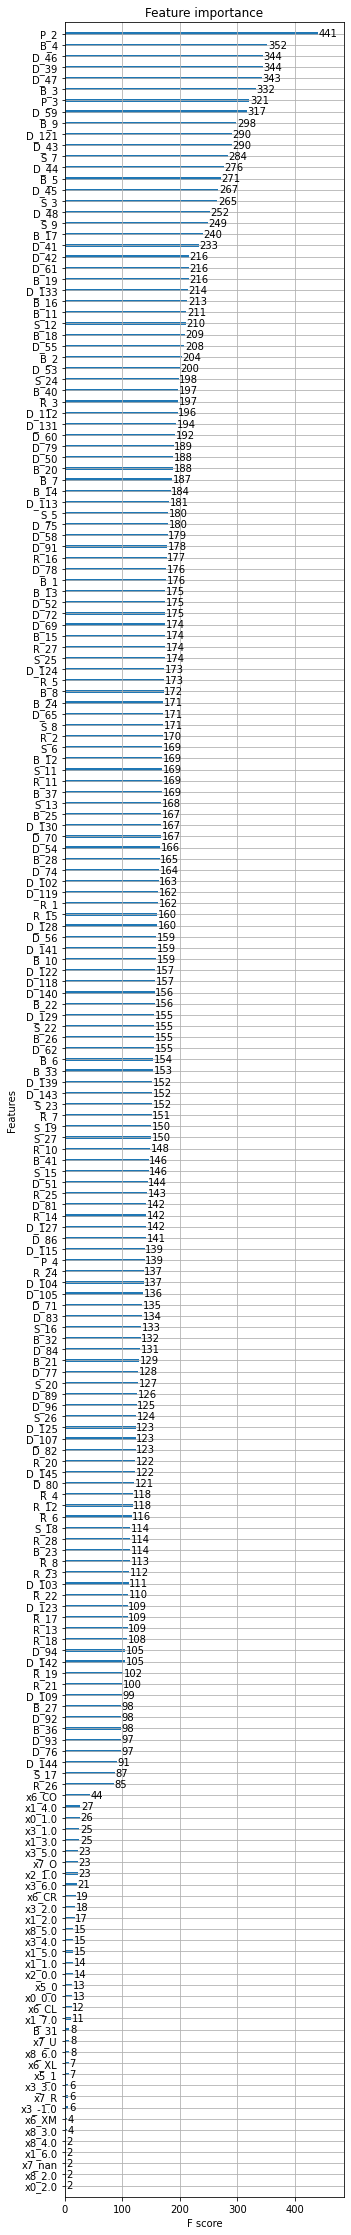

In [199]:
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(5, 40)

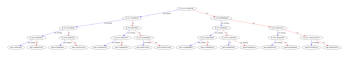

In [202]:
xgb.plot_tree(bst, num_trees=2)
fig = ax.figure
fig.set_size_inches(40, 40)

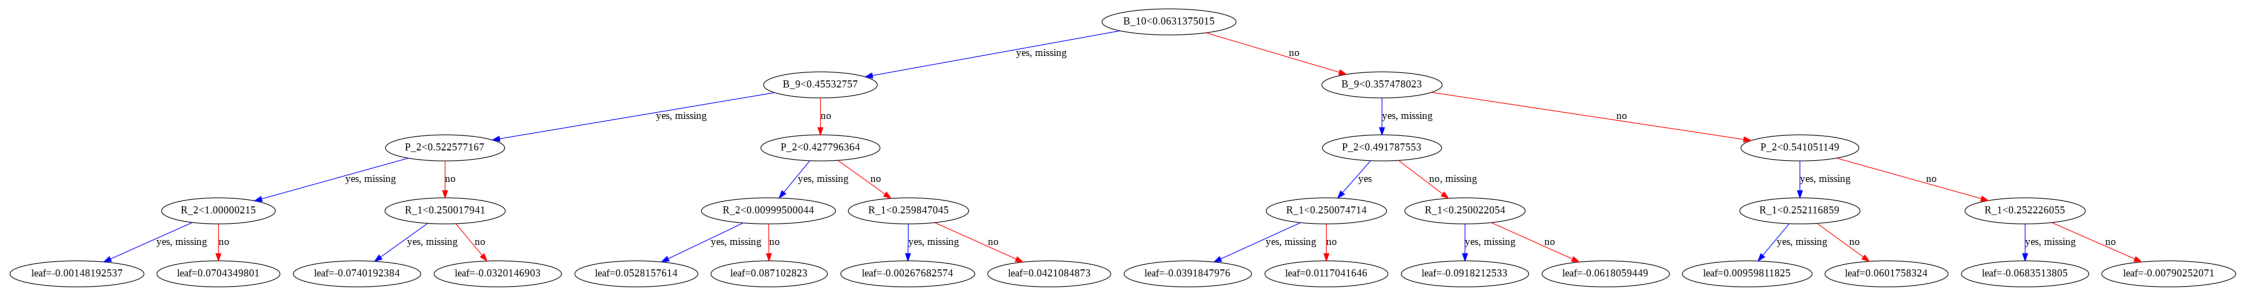

In [222]:
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 40,50

plot_tree(bst, num_trees=1)

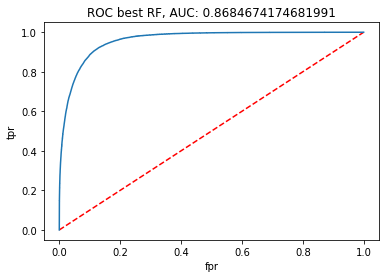

In [225]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores, pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

In [226]:
predicted_labels = np.where(predicted_scores > 0.5, 1, 0)

In [227]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_labels)

array([[63658,  4302],
       [ 4653, 19170]])

In [228]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

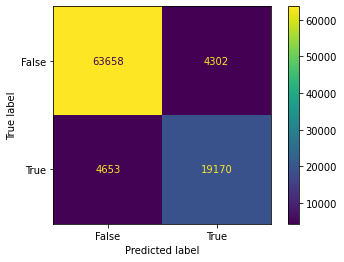

In [229]:
cm_display.plot()
plt.show()

In [230]:
Precision = metrics.precision_score(y_test, predicted_labels)
Sensitivity_recall = metrics.recall_score(y_test, predicted_labels)
print(Precision)
print(Sensitivity_recall)

0.816717791411043
0.8046845485455232


In [ ]:
param = {'max_depth': [2,4,6], 'eta': [0.01,0.1,0.3], 'colsample_bynode': [0.2, 0.5, 0.6], }
#param['eval_metric'] = 'logloss'

In [ ]:
xgb_m = xgb.XGBClassifier(learning_rate=0.02, n_estimators=2000, objective='binary:logistic')

In [ ]:
folds = 2
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_m, param_distributions=param, n_iter=param_comb, scoring='neg_log_loss', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
#start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
#timer(start_time) # timing ends here for "start_time" variable

Fitting 2 folds for each of 5 candidates, totalling 10 fits


KeyboardInterrupt: ignored

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

En el entrendamiento tenemos 344,184 valores para los predictores y 344,18 para la variable target.

Clasificadores interesenates para probar:
- GradientBoostingClassifier -> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

- HistGradientBoostingClassifier -> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier---->This estimator is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000) and this implementation is inspired by LightGBM. 

Scikit-learn 0.21 introduced two new implementations of gradient boosting trees, namely HistGradientBoostingClassifier and HistGradientBoostingRegressor, inspired by LightGBM (See [LightGBM]).

These histogram-based estimators can be orders of magnitude faster than GradientBoostingClassifier and GradientBoostingRegressor when the number of samples is larger than tens of thousands of samples.

They also have built-in support for missing values, which avoids the need for an imputer.

Scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter


In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting 
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.8/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
param = {'max_depth': 10, 'eta': 0.1, 'objective': 'binary:logistic'}
param['eval_metric'] = 'logloss'
evallist = [(Xtrain, 'train'), (Xtest, 'eval')]

In [ ]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)


bst = XGBClassifier(n_estimators=2, max_depth=10, learning_rate=0.1, objective='binary:logistic')

In [ ]:
from sklearn.model_selection import ParameterGrid, GridSearchCV
#from sklearn.ensemble import HistGradientBoostingClassifier

dt = HistGradientBoostingClassifier(random_state=5432)

grid = {'min_samples_leaf': [5,10],'learning_rate': [0.001,0.01,0.1],'max_depth': [5,10],'max_iter':[1500,2000],
       'l2_regularization':[1,1.5]}
# En scoring es la manera en que va a escoger el mejor tree, los más comunes son recall y precision
# n-jobs ayuda a que sea mas eficiente en recursos, en -1 ocupa todo lo que esta disponible

gs = GridSearchCV(dt, param_grid=grid, scoring='recall', cv=5, n_jobs=30,
                  return_train_score=True)
gs.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


##### Co'digo para cuando tengamos mas variaciones en el gridsearch

In [ ]:
type(gs)

sklearn.model_selection._search.GridSearchCV

In [ ]:
#Encontrar el mejor modelo
gs.best_estimator_ 

HistGradientBoostingClassifier(l2_regularization=1.5, max_depth=10,
                               max_iter=1000, min_samples_leaf=10,
                               random_state=5432)

In [ ]:
gs.best_params_

{'l2_regularization': 1.5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'max_iter': 1000,
 'min_samples_leaf': 10}

In [ ]:
# obtiene las etiquetas del mejor predictor
predicted_labels = gs.predict(X_test)
predicted_labels[:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
# scores asociados
predicted_scores = gs.predict_proba(X_test)
predicted_scores[:10,]

array([[9.97210187e-01, 2.78981293e-03],
       [9.97988932e-01, 2.01106760e-03],
       [6.94436541e-01, 3.05563459e-01],
       [6.24825529e-01, 3.75174471e-01],
       [9.99066085e-01, 9.33914763e-04],
       [9.46448082e-01, 5.35519179e-02],
       [5.44295208e-02, 9.45570479e-01],
       [6.56512384e-02, 9.34348762e-01],
       [8.66121423e-01, 1.33878577e-01],
       [9.98074068e-01, 1.92593156e-03]])

Este es el score asociado a que defaulte o no. Mientras más grande sea, más seguro está el modelo de que corresponde a la etiqueta positiva (defaultea). Mientras más cercano a 0, menos está seguro de que es 1(defaulte) y pone 0 (no defaultea).

La primer columna correpsonde a la etiqueta 0 y la segunda columna a la etiqueta 1.

In [ ]:
#El mejor modelo
dt = HistGradientBoostingClassifier(min_samples_leaf=10, learning_rate=0.1,max_depth=10,
                                    max_iter=1000,l2_regularization=1.5, random_state=5432)
dt.fit(X_train, y_train)

print("Tiempo de ejecución en segundos: {}".format(time.time() - start))

HistGradientBoostingClassifier(l2_regularization=1.5, max_depth=10,
                               max_iter=1000, min_samples_leaf=10,
                               random_state=5432)

In [ ]:
dt.n_features_in_ #Number of features seen during fit.

202

### Métricas de Desempeño

<ipython-input-64-95b877ac174c>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1],[0,1], 'k--', c="red")


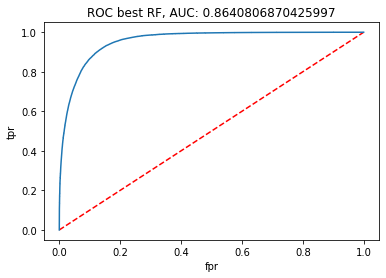

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()


Cubrimos un área bajo la curva del 86.40% y mientras más cercano esté a 1 significa que esta curva está más paradita y es mejor. Aunque un área bajo la curva mayor sería mejor, esta no es una buena forma de medir si un modelo es o no el mejor. 

Si la AUC fuera 1, entonces el modelo de clasificación puede distinguir correctamente entre las etiquetas poisitivas y negativas. Como la AUC está entre 1 y 0.5, el modelo puede detectar más veces True positives y True negatives que False negatives y False positives.  

**Matriz de Confusión**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_labels)

array([[78950,  5939],
       [ 6024, 23816]])

- Tenemos 78950 Verdaderos Negativos (TN)
- Tenemos 23816 Verdaderos Positivos (TP)
- Tenemos 5939 Falsos Positivos (FP)
- Tenemos 6024 Falsos Negativos (FN)

Nuestro objetivo es atinarle a las cosas que decimos que son positivas que sean positivas y tenemos más de esas en proporción a los errores, queremos recall y tiene que ver con Falsos Negativos.  Todavía no es la matriz en el punto de corte pero en proporción tenemos muchos más aciertos (102,766 aciertos) que errores (11,963), por lo que el modelo se ve bien. 

In [ ]:
recall=23816/(23816+6024)
recall

0.7981233243967828

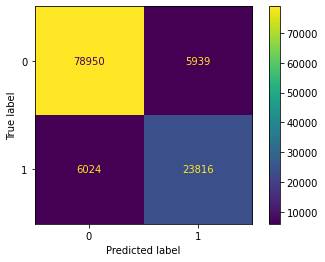

In [ ]:
#Plot de la matriz de confusión usando la librería sklearn
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gs, X_test, y_test)  
plt.show() 

**Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted_labels)

0.8957281942664889

Accuracy mide cómo nos va en aciertos tanto negativos como positivos. Mientras más cercano a 1 quiere decir que se tuvieron más aciertos y obtuvimos 0.89 de accuracy. No se sugiere ocupar accuracy para medir el desempeño porque casi nunca van a estar balanceados los data sets y hace más difícil encontrar un 1 que un 0.

**Curva Precision-Recall**

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1])

(precision, recall, thresholds_2)

(array([0.27470656, 0.27469988, 0.27470241, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99966488e-01, 9.99966488e-01, ...,
        6.70241287e-05, 3.35120643e-05, 0.00000000e+00]),
 array([9.06380084e-04, 9.06436999e-04, 9.06455319e-04, ...,
        9.98955496e-01, 9.99113887e-01, 9.99326424e-01]))

In [ ]:
(precision.shape, recall.shape, thresholds_2.shape)

((108626,), (108626,), (108625,))

In [ ]:
# agregaremos a los thresholds un punto más para que cuadren
thresholds_2 = np.append(thresholds_2, 1)

In [ ]:
(precision.shape, recall.shape, thresholds_2.shape)

((108626,), (108626,), (108626,))

<Figure size 432x288 with 0 Axes>

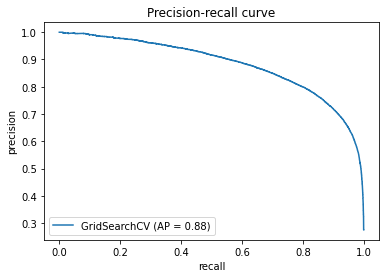

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

plt.clf()
plot_precision_recall_curve(gs, X_test, y_test)
plt.title("Precision-recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

**Para un precision de 70% se tiene como un 93% de recall**

In [ ]:
from sklearn.metrics import f1_score

f1_score = f1_score(y_test, predicted_labels, labels=[0,1],  pos_label=1)
f1_score

0.7992616830270997

### Tabla de métricas de desempeño

In [ ]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [ ]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report.head(3)

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.000906,0.274707,1.000000,0.431011,1.000000,0.928094,0.071906,0.000000
1,0.000906,0.274700,0.999966,0.431000,0.999966,0.928094,0.071906,0.000034
2,0.000967,0.276913,0.999966,0.433719,0.999966,0.917869,0.082131,0.000034


 ### Test Data

In [ ]:
#read in test data
test = pd.read_csv("/Users/Shanti/Desktop/test_data.csv")

In [ ]:
#predict on test with gs 
submission_pred = gs.predict(test)
submission_pred.head(5)